In [1]:
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [2]:
import xarray as xr
import numpy as np
import os

# List of NetCDF file paths
file_paths = ['./New folder/NC/landsat2000.nc', './New folder/NC/landsat2001.nc',
              './New folder/NC/landsat2002.nc', './New folder/NC/landsat2003.nc',
              './New folder/NC/landsat2004.nc', './New folder/NC/landsat2005.nc',
             './New folder/NC/landsat2006.nc', './New folder/NC/landsat2007.nc',
              './New folder/NC/landsat2008.nc', './New folder/NC/landsat2009.nc',
              './New folder/NC/landsat2010.nc', './New folder/NC/landsat2011.nc',
             './New folder/NC/landsat2012.nc', './New folder/NC/landsat2013.nc',
              './New folder/NC/landsat2014.nc', './New folder/NC/landsat2015.nc',
              './New folder/NC/landsat2016.nc', './New folder/NC/landsat2017.nc',
             './New folder/NC/landsat2018.nc', './New folder/NC/landsat2019.nc',
              './New folder/NC/landsat2020.nc', './New folder/NC/landsat2021.nc',
              './New folder/NC/landsat2022.nc', './New folder/NC/landsat2023.nc',
             './New folder/NC/landsat2024.nc']  # Replace with your file paths

# Name of the variable you want to extract
# variable_name = 'band1'  # Replace with the actual variable name

# Initialize an empty list to store NumPy arrays
data_list = []

# Loop through each file, load the variable, and append to the list
for file_path in file_paths:
    temporarial = []
    if os.path.exists(file_path):  # Check if the file exists
        print(f"Loading file: {file_path}")

        # Open the file using xarray
        dataset = xr.open_dataset(file_path)
        dataset = dataset.fillna(0)
        for variable_name in ['Band1', 'Band2', 'Band3', 'Band4', 'Band5']:#, 'band6', 'band7']:
            # Extract the variable as a NumPy array and append to the list
            data_array = dataset[variable_name].values  # Extract data as NumPy array
            temporarial.append(data_array)
            # print(f"Shape of data from {file_path}: {data_array.shape}")
    data_list.append(temporarial)



# At this point, 'combined_data' contains all the concatenated data.


Loading file: ./New folder/NC/landsat2000.nc


C:\Users\decis\anaconda3\envs\kaveh\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


Loading file: ./New folder/NC/landsat2001.nc
Loading file: ./New folder/NC/landsat2002.nc
Loading file: ./New folder/NC/landsat2003.nc
Loading file: ./New folder/NC/landsat2004.nc
Loading file: ./New folder/NC/landsat2005.nc
Loading file: ./New folder/NC/landsat2006.nc
Loading file: ./New folder/NC/landsat2007.nc
Loading file: ./New folder/NC/landsat2008.nc
Loading file: ./New folder/NC/landsat2009.nc
Loading file: ./New folder/NC/landsat2010.nc
Loading file: ./New folder/NC/landsat2011.nc
Loading file: ./New folder/NC/landsat2012.nc
Loading file: ./New folder/NC/landsat2013.nc
Loading file: ./New folder/NC/landsat2014.nc
Loading file: ./New folder/NC/landsat2015.nc
Loading file: ./New folder/NC/landsat2016.nc
Loading file: ./New folder/NC/landsat2017.nc
Loading file: ./New folder/NC/landsat2018.nc
Loading file: ./New folder/NC/landsat2019.nc
Loading file: ./New folder/NC/landsat2020.nc
Loading file: ./New folder/NC/landsat2021.nc
Loading file: ./New folder/NC/landsat2022.nc
Loading fi

In [3]:
np.array(data_list).shape

(25, 5, 1825, 1867)

In [4]:
final_array = np.array(data_list)

In [5]:
# def build_grid_edge_index(H, W, device=None):
#     """
#     Build 4-neighbour grid edges for an HxW image.
#     Returns edge_index of shape [2, num_edges].
#     """
#     # Node ids: 0..(H*W-1), arranged row-major
#     idx = torch.arange(H * W, dtype=torch.long).view(H, W)

#     # Horizontal edges (left-right)
#     right = idx[:, :-1].reshape(-1)
#     left  = idx[:,  1:].reshape(-1)
#     horiz_edges = torch.stack([right, left], dim=0)  # right -> left
#     horiz_edges_rev = torch.stack([left, right], dim=0)  # left -> right

#     # Vertical edges (up-down)
#     down = idx[:-1, :].reshape(-1)
#     up   = idx[ 1:, :].reshape(-1)
#     vert_edges = torch.stack([down, up], dim=0)  # down -> up
#     vert_edges_rev = torch.stack([up, down], dim=0)  # up -> down

#     edge_index = torch.cat(
#         [horiz_edges, horiz_edges_rev, vert_edges, vert_edges_rev],
#         dim=1
#     )

#     if device is not None:
#         edge_index = edge_index.to(device)

#     return edge_index
def build_grid_edge_index(H, W, device=None):
    """
    Build 8-neighbour grid edges (4-neighbour + diagonals) for an HxW image.
    Returns edge_index of shape [2, num_edges].
    """
    # Node ids: 0..(H*W-1), arranged row-major
    idx = torch.arange(H * W, dtype=torch.long).view(H, W)

    # ---------- 4-neighbour (von Neumann) ----------

    # Horizontal edges (left-right)
    right = idx[:, :-1].reshape(-1)
    left  = idx[:,  1:].reshape(-1)
    horiz_edges = torch.stack([right, left], dim=0)        # right -> left
    horiz_edges_rev = torch.stack([left, right], dim=0)    # left -> right

    # Vertical edges (up-down)
    down = idx[:-1, :].reshape(-1)
    up   = idx[ 1:, :].reshape(-1)
    vert_edges = torch.stack([down, up], dim=0)            # down -> up
    vert_edges_rev = torch.stack([up, down], dim=0)        # up -> down

    # ---------- Diagonals (add 4 more directions) ----------

    # Down-right diagonal: (i, j) -> (i+1, j+1)
    dr_src = idx[:-1, :-1].reshape(-1)
    dr_dst = idx[ 1:,  1:].reshape(-1)
    dr_edges = torch.stack([dr_src, dr_dst], dim=0)
    dr_edges_rev = torch.stack([dr_dst, dr_src], dim=0)

    # Down-left diagonal: (i, j) -> (i+1, j-1)
    dl_src = idx[:-1, 1:].reshape(-1)
    dl_dst = idx[ 1:, :-1].reshape(-1)
    dl_edges = torch.stack([dl_src, dl_dst], dim=0)
    dl_edges_rev = torch.stack([dl_dst, dl_src], dim=0)

    # ---------- Concatenate all edges ----------

    edge_index = torch.cat(
        [
            horiz_edges, horiz_edges_rev,
            vert_edges, vert_edges_rev,
            dr_edges, dr_edges_rev,
            dl_edges, dl_edges_rev,
        ],
        dim=1,
    )

    if device is not None:
        edge_index = edge_index.to(device)

    return edge_index



def year_pair_to_graph(data_4d, year_idx, stride=1, device=None, dtype=torch.float32):
    """
    Convert one pair (year_idx -> year_idx+1) into a PyG Data object.

    Parameters
    ----------
    data_4d : np.ndarray or torch.Tensor
        Shape (T, C, H, W) e.g. (25, 5, 1825, 1867)
    year_idx : int
        Index t (0 <= t < T-1); we build graph from year t -> t+1
    stride : int, optional
        Spatial downsampling factor: take every `stride`th pixel.
        E.g. stride=4 reduces H,W by 4.
    device : torch.device or str, optional
        Device for tensors (e.g. "cuda" or "cpu").
    dtype : torch.dtype, optional
        Data type for x and y (default: float32).

    Returns
    -------
    Data
        PyTorch Geometric Data object with:
        - x: [N, C] features for year t
        - y: [N, C] regression targets for year t+1
        - edge_index: [2, E] grid edges
        - H, W: original height/width after downsampling (stored as attributes)
    """
    if isinstance(data_4d, np.ndarray):
        data_4d = torch.from_numpy(data_4d)

    # data_4d: (T, C, H, W)
    T, C, H, W = data_4d.shape
    assert 0 <= year_idx < T - 1, "year_idx must be in [0, T-2]"

    # Extract year t and t+1, with optional spatial downsampling
    x_t = data_4d[year_idx, :, ::stride, ::stride]      # (C, H', W')
    y_tp1 = data_4d[year_idx + 1, :, ::stride, ::stride]  # (C, H', W')

    C, Hs, Ws = x_t.shape

    # Flatten spatial dims so nodes=H'*W'
    # x: [N, C], y: [N, C]
    x = x_t.reshape(C, Hs * Ws).transpose(0, 1).to(dtype)   # (N, C)
    y = y_tp1.reshape(C, Hs * Ws).transpose(0, 1).to(dtype) # (N, C)

    # Build edges for the H' x W' grid
    edge_index = build_grid_edge_index(Hs, Ws, device=device)

    if device is not None:
        x = x.to(device)
        y = y.to(device)

    data = Data(x=x, edge_index=edge_index, y=y)
    data.H = Hs
    data.W = Ws
    data.year_t = int(year_idx)  # optional metadata

    return data


In [6]:
device = "cpu"  # or "cpu"
stride = 2       # try 4 or 8 first!

graphs = []
T = final_array.shape[0]

for t in range(T - 1):
    g = year_pair_to_graph(
        final_array,
        year_idx=t,
        stride=stride,
        device=device
    )
    graphs.append(g)

print(len(graphs))          # 24 graphs
print(graphs[0])            # inspect one
print(graphs[0].x.shape)    # [N, 5]
print(graphs[0].y.shape)    # [N, 5]
print(graphs[0].edge_index.shape)

24
Data(x=[852742, 5], edge_index=[2, 6810858], y=[852742, 5], H=913, W=934, year_t=0)
torch.Size([852742, 5])
torch.Size([852742, 5])
torch.Size([2, 6810858])


In [7]:
class GCNRegressor(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels=64,
        out_channels=None,
        num_gcn_layers=3,
        mlp_hidden_channels=64,
        mlp_num_layers=2,
        dropout=0.0,
    ):
        """
        GCN backbone + MLP head for node-wise regression.

        in_channels        : input feature dim (your C, e.g. 5)
        hidden_channels    : hidden dim in GCN layers
        out_channels       : output feature dim (default = in_channels)
        num_gcn_layers     : number of GCNConv layers
        mlp_hidden_channels: hidden dim in MLP head
        mlp_num_layers     : number of Linear layers in MLP (>=1)
        dropout            : dropout between GCN layers and inside MLP
        """
        super().__init__()

        if out_channels is None:
            out_channels = in_channels

        # --------- GCN backbone ---------
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))

        for _ in range(num_gcn_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.dropout = dropout

        # --------- MLP head ---------
        mlp_layers = []
        in_dim = hidden_channels
        for i in range(mlp_num_layers - 1):
            mlp_layers.append(nn.Linear(in_dim, mlp_hidden_channels))
            mlp_layers.append(nn.ReLU())
            if dropout > 0:
                mlp_layers.append(nn.Dropout(dropout))
            in_dim = mlp_hidden_channels

        # final layer to out_channels (no activation here; regression)
        mlp_layers.append(nn.Linear(in_dim, out_channels))

        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x, edge_index):
        # x: [N, in_channels]
        # edge_index: [2, E]
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)

        # MLP head
        out = self.mlp(x)   # [N, out_channels]
        return out



In [9]:

# ==========================================================
# 1) Load your NumPy data  (T, C, H, W) = (25, 5, 1825, 1867)
# ==========================================================
# Example: adjust this to your actual loading method
# data_np = np.load("your_25x5x1825x1867.npy")
# Here I'll just show the variable name we expect:

# Check shape
assert final_array.ndim == 4, "Expected data shape (T, C, H, W)"
T, C, H, W = final_array.shape
print("Data shape:", final_array.shape)

# ==========================================================
# 3) Train/val split over time (e.g. first 18 transitions train, last 6 val)
# ==========================================================
num_graphs = len(graphs)
split = int(num_graphs * 0.75)  # 75% train, 25% val

train_graphs = graphs[:]
val_graphs   = graphs[split:]

print(f"Train graphs: {len(train_graphs)}, Val graphs: {len(val_graphs)}")

# ==========================================================
# 4) PyG DataLoaders
# ==========================================================
batch_size = 1  # start with 1; you can increase if memory allows
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=batch_size, shuffle=False)

# ==========================================================
# 5) Model, optimizer, device
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# C = data_np.shape[1]  # number of channels, e.g. 5

model = GCNRegressor(
    in_channels=C,
    hidden_channels=64,
    out_channels=C,
    num_gcn_layers=2,       # GCN depth
    mlp_hidden_channels=64, # MLP hidden size
    mlp_num_layers=2,       # 1 hidden + 1 output layer
    dropout=0.1,
).to(device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# ==========================================================
# 6) Training loop
# ==========================================================
num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(1, num_epochs + 1):
    # ---- Train ----
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        # Move entire batch to device (x, edge_index, y, etc.)
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)  # [N_nodes_total_in_batch, C]

        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs  # scale by count
    
    train_loss /= len(train_graphs)
    train_losses.append(train_loss)
    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item() * batch.num_graphs

    val_loss /= max(len(val_graphs), 1)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")


Data shape: (25, 5, 1825, 1867)
Train graphs: 24, Val graphs: 6
Using device: cpu
Epoch 001 | Train MSE: 0.011541 | Val MSE: 0.004158
Epoch 002 | Train MSE: 0.002650 | Val MSE: 0.001623
Epoch 003 | Train MSE: 0.001143 | Val MSE: 0.001310
Epoch 004 | Train MSE: 0.001042 | Val MSE: 0.001357
Epoch 005 | Train MSE: 0.000982 | Val MSE: 0.001337
Epoch 006 | Train MSE: 0.000943 | Val MSE: 0.001380
Epoch 007 | Train MSE: 0.000906 | Val MSE: 0.001395
Epoch 008 | Train MSE: 0.000870 | Val MSE: 0.001241
Epoch 009 | Train MSE: 0.000790 | Val MSE: 0.001121
Epoch 010 | Train MSE: 0.000758 | Val MSE: 0.000994
Epoch 011 | Train MSE: 0.000717 | Val MSE: 0.001071
Epoch 012 | Train MSE: 0.000698 | Val MSE: 0.000928
Epoch 013 | Train MSE: 0.000694 | Val MSE: 0.000937
Epoch 014 | Train MSE: 0.000690 | Val MSE: 0.001076
Epoch 015 | Train MSE: 0.000651 | Val MSE: 0.000812
Epoch 016 | Train MSE: 0.000645 | Val MSE: 0.000804
Epoch 017 | Train MSE: 0.000646 | Val MSE: 0.000889
Epoch 018 | Train MSE: 0.000622 | 

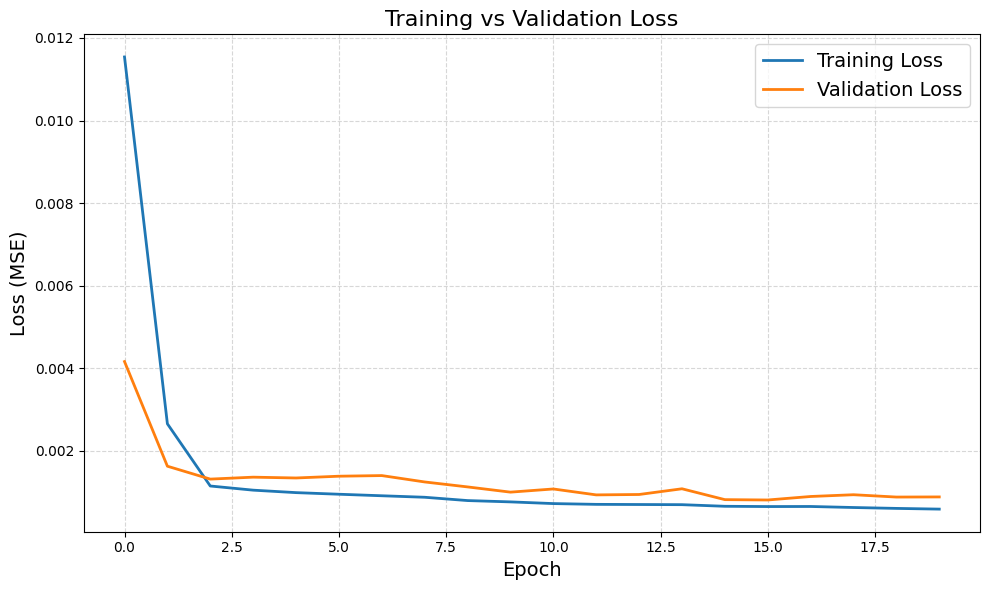

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss (MSE)", fontsize=14)
plt.title("Training vs Validation Loss", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# After training, `model` predicts next-year node values from current year.
# Example inference on the last graph:
test_graph = graphs[-1].to(device)
with torch.no_grad():
    pred_next_year = model(test_graph.y, test_graph.edge_index)  # [N_nodes, C]

print("Inference done on last year graph; pred shape:", pred_next_year.shape)

Inference done on last year graph; pred shape: torch.Size([852742, 5])


In [12]:
def graph_nodes_to_image(node_features, H, W):
    """
    Convert node features [N, C] back to image [C, H, W].

    node_features : torch.Tensor or np.ndarray, shape [N, C]
        N must equal H * W.
    H, W : int
        Height and width of the downsampled grid (e.g. data.H, data.W).

    Returns
    -------
    img : torch.Tensor, shape [C, H, W]
    """
    if isinstance(node_features, np.ndarray):
        node_features = torch.from_numpy(node_features)

    N, C = node_features.shape
    assert N == H * W, f"N={N} != H*W={H*W}"

    # [N, C] -> [H, W, C] -> [C, H, W]
    img = node_features.view(H, W, C).permute(2, 0, 1).contiguous()
    return img


In [13]:
# test_graph: a Data object with attributes H, W
Hs, Ws = test_graph.H, test_graph.W

pred_img_down = graph_nodes_to_image(pred_next_year, Hs, Ws)  # [C, H', W']
print(pred_img_down.shape)


torch.Size([5, 913, 934])


In [14]:
def upscale_to_full_resolution(img_down, stride, full_H=None, full_W=None, mode="nearest"):
    """
    Upscale a downsampled image [C, H', W'] back to [C, H, W].

    img_down : torch.Tensor, shape [C, H', W']
    stride   : int, the downsampling factor used when creating graphs.
    full_H, full_W : int, optional. If None, assumed stride * H', stride * W'.
    mode : str, interpolation mode ("nearest", "bilinear", etc.)

    Returns
    -------
    img_full : torch.Tensor, shape [C, full_H, full_W]
    """
    C, Hs, Ws = img_down.shape

    if full_H is None:
        full_H = Hs * stride
    if full_W is None:
        full_W = Ws * stride

    # interpolate expects [N, C, H, W]
    img_down_b = img_down.unsqueeze(0)  # [1, C, H', W']
    img_full_b = F.interpolate(img_down_b, size=(full_H, full_W), mode=mode)
    img_full = img_full_b.squeeze(0)    # [C, H, W]
    return img_full


In [15]:
# Suppose you used stride=4 when building graphs
stride = 2

# Downsampled predicted image (C, H', W')
pred_img_down = graph_nodes_to_image(pred_next_year, test_graph.H, test_graph.W)

# If you know original H, W = data_np.shape[2], data_np.shape[3]:
H_full, W_full = final_array.shape[2], final_array.shape[3]

pred_img_full = upscale_to_full_resolution(
    pred_img_down,
    stride=stride,
    full_H=H_full,
    full_W=W_full,
    mode="nearest"  # or "bilinear"
)

print("Downsampled:", pred_img_down.shape)  # [C, H', W']
print("Full res   :", pred_img_full.shape)  # [C, H, W]

Downsampled: torch.Size([5, 913, 934])
Full res   : torch.Size([5, 1825, 1867])


In [16]:
pred_img_full_np = pred_img_full.cpu().numpy()  # [C, H, W]

In [17]:
pred_img_full = pred_img_full_np  # shape (5, 1825, 1867)
C, H, W = pred_img_full.shape

In [18]:
x=dataset["lon"]
y=dataset["lat"]

In [19]:
# Make sure x (lon) and y (lat) have these lengths:
# len(y) == H, len(x) == W
# (you said original grid is 1825 x 1867, so y length 1825, x length 1867)
assert len(y) == H, f"len(y)={len(y)} but H={H}"
assert len(x) == W, f"len(x)={len(x)} but W={W}"

band_names = [f"Band{i+1}" for i in range(C)]

ds = xr.Dataset(
    {
        # Each band is a 2D field over (lat, lon)
        band_names[i]: (("lat", "lon"), pred_img_full[i, :, :])
        for i in range(C)
    },
    coords={
        "lat": y,
        "lon": x,
    },
)

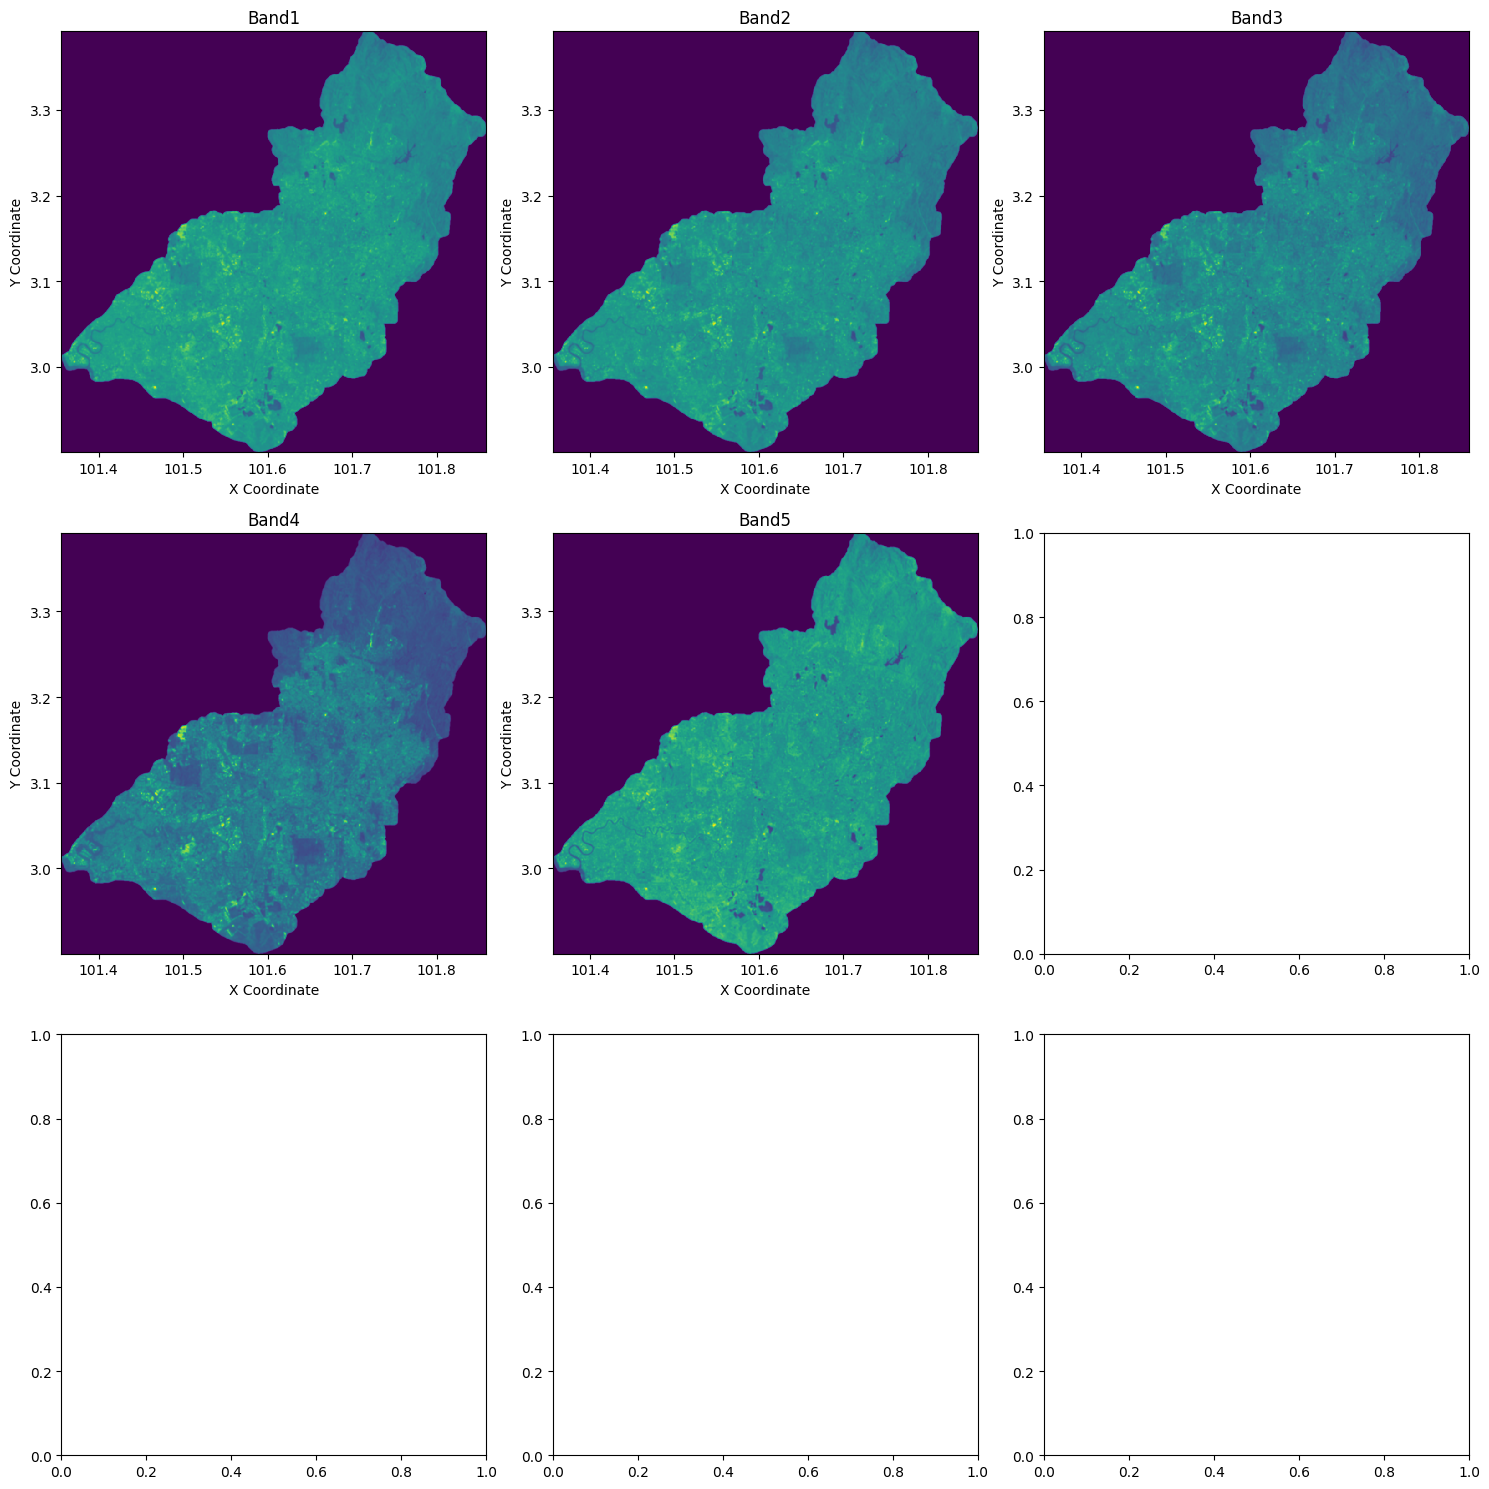

In [20]:
bands = ["Band1", "Band2", "Band3", "Band4", "Band5"]  # Replace with actual names

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust grid size as needed
axes = axes.flatten()

for i, band in enumerate(bands):
    if i < len(axes):
        data_band = ds[band]
        axes[i].pcolormesh(x, y, data_band, shading='auto', cmap='viridis')
        axes[i].set_title(band)
        axes[i].set_xlabel("X Coordinate")
        axes[i].set_ylabel("Y Coordinate")

plt.tight_layout()
plt.show()

In [21]:
output_file = "output_GCN_2025.nc"
ds.to_netcdf(output_file)

# Evaluation

In [22]:
model.eval()

# graph for 2023 -> 2024
test_graph = graphs[-1].to(device)

with torch.no_grad():
    pred_nodes = model(test_graph.x, test_graph.edge_index)   # shape [N_nodes, C]


In [23]:
# Suppose you used stride=4 when building graphs
stride = 2

# Downsampled predicted image (C, H', W')
pred_img_down = graph_nodes_to_image(pred_nodes, test_graph.H, test_graph.W)

# If you know original H, W = data_np.shape[2], data_np.shape[3]:
H_full, W_full = final_array.shape[2], final_array.shape[3]

pred_img_full = upscale_to_full_resolution(
    pred_img_down,
    stride=stride,
    full_H=H_full,
    full_W=W_full,
    mode="nearest"  # or "bilinear"
)

print("Downsampled:", pred_img_down.shape)  # [C, H', W']
print("Full res   :", pred_img_full.shape)  # [C, H, W]

Downsampled: torch.Size([5, 913, 934])
Full res   : torch.Size([5, 1825, 1867])


In [24]:
actual_2024 = final_array[24]   # shape (5, H, W), since index 24 = year 2024

In [25]:
from sklearn.metrics import r2_score

# flatten all channels
y_true = actual_2024.reshape(-1)
y_pred = pred_img_full.reshape(-1)

r2_overall = r2_score(y_true, y_pred)
print("R² (overall):", r2_overall)

R² (overall): 0.9258823394775391


In [26]:
for c in range(C):
    r2_c = r2_score(actual_2024[c].reshape(-1),
                    pred_img_full[c].reshape(-1))
    print(f"R² for channel {c}: {r2_c:.4f}")

R² for channel 0: 0.9679
R² for channel 1: 0.9506
R² for channel 2: 0.9231
R² for channel 3: 0.8344
R² for channel 4: 0.9098


# Do for five consequative years

In [27]:
import torch

def autoregressive_forecast_nodes(model, last_graph, num_steps, device):
    """
    Autoregressively predict `num_steps` future years on the same grid as `last_graph`.

    Parameters
    ----------
    model : nn.Module
        Trained GCN model.
    last_graph : torch_geometric.data.Data
        Graph where `last_graph.y` is the features of the last known year (e.g. 2024),
        and `last_graph.edge_index` defines the topology.
    num_steps : int
        Number of future steps to predict (e.g. 5).
    device : torch.device or str
        "cuda" or "cpu".

    Returns
    -------
    future_preds_nodes : list of torch.Tensor
        List of length `num_steps`, each tensor of shape [N_nodes, C],
        containing predicted node features for each future year.
        Step 0 = year T+1, step 1 = T+2, etc.
    """
    model.eval()

    edge_index = last_graph.edge_index.to(device)
    # Start from the last known year features: year T (e.g. 2024)
    x_current = last_graph.y.to(device)   # [N, C]

    future_preds_nodes = []

    with torch.no_grad():
        for step in range(num_steps):
            # Predict next year's features
            y_pred = model(x_current, edge_index)  # [N, C]

            # Store prediction (on CPU)
            future_preds_nodes.append(y_pred.cpu())

            # Feed prediction as input for the next step
            x_current = y_pred

    return future_preds_nodes


In [28]:
num_future_years = 5

last_graph = graphs[-1]  # 2023 -> 2024 graph
future_preds_nodes = autoregressive_forecast_nodes(
    model,
    last_graph=last_graph,
    num_steps=num_future_years,
    device=device,
)

print(len(future_preds_nodes))          # 5
print(future_preds_nodes[0].shape)      # [N_nodes, C]


5
torch.Size([852742, 5])


In [29]:
# Suppose you used stride=4 when building graphs
stride = 2

# Downsampled predicted image (C, H', W')
pred_img_down = graph_nodes_to_image(future_preds_nodes[-1], test_graph.H, test_graph.W)

# If you know original H, W = data_np.shape[2], data_np.shape[3]:
H_full, W_full = final_array.shape[2], final_array.shape[3]

pred_img_full = upscale_to_full_resolution(
    pred_img_down,
    stride=stride,
    full_H=H_full,
    full_W=W_full,
    mode="nearest"  # or "bilinear"
)

print("Downsampled:", pred_img_down.shape)  # [C, H', W']
print("Full res   :", pred_img_full.shape)  # [C, H, W]

Downsampled: torch.Size([5, 913, 934])
Full res   : torch.Size([5, 1825, 1867])


In [30]:
pred_img_full_np = pred_img_full.cpu().numpy()  # [C, H, W]
pred_img_full = pred_img_full_np  # shape (5, 1825, 1867)
C, H, W = pred_img_full.shape

In [31]:
x=dataset["lon"]
y=dataset["lat"]

In [32]:
# Make sure x (lon) and y (lat) have these lengths:
# len(y) == H, len(x) == W
# (you said original grid is 1825 x 1867, so y length 1825, x length 1867)
assert len(y) == H, f"len(y)={len(y)} but H={H}"
assert len(x) == W, f"len(x)={len(x)} but W={W}"

band_names = [f"Band{i+1}" for i in range(C)]

ds = xr.Dataset(
    {
        # Each band is a 2D field over (lat, lon)
        band_names[i]: (("lat", "lon"), pred_img_full[i, :, :])
        for i in range(C)
    },
    coords={
        "lat": y,
        "lon": x,
    },
)

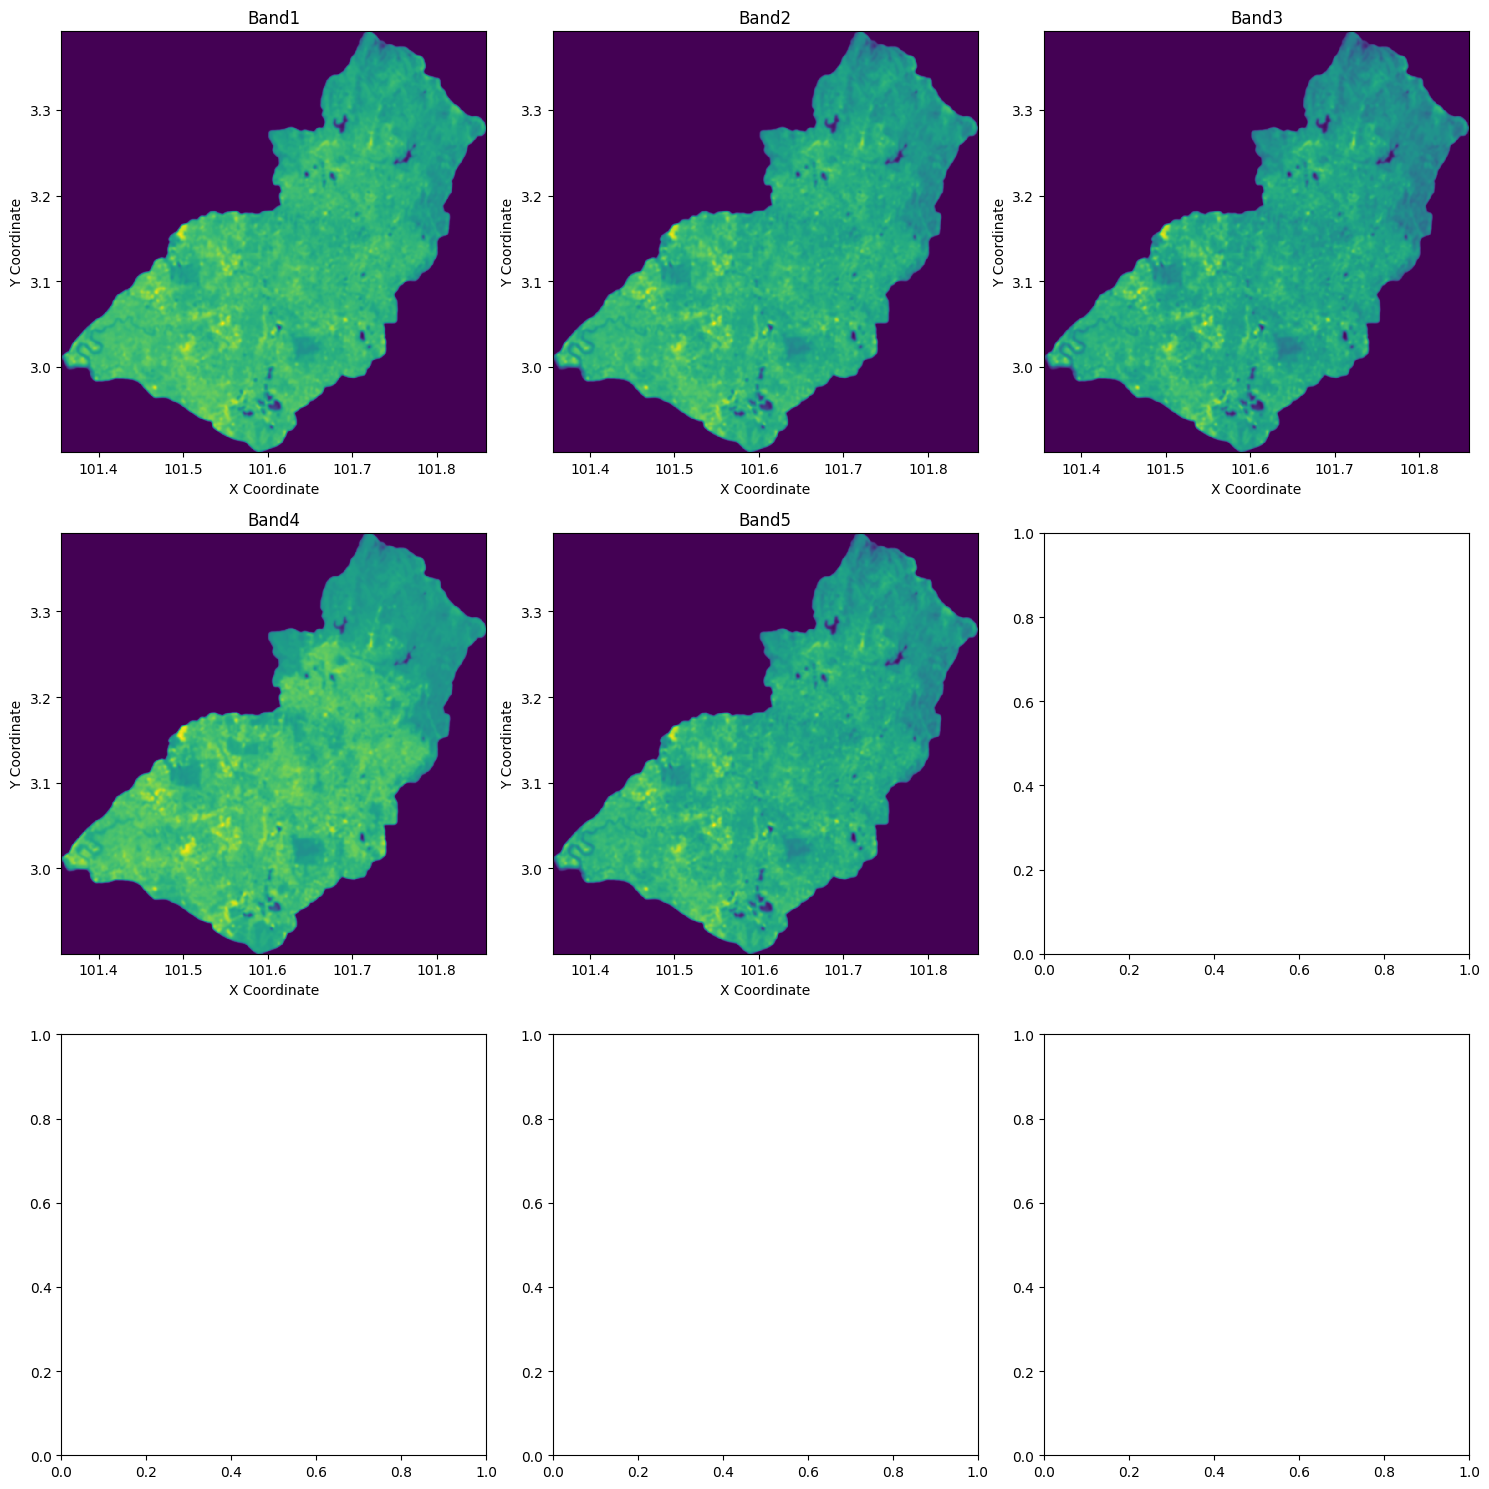

In [33]:
bands = ["Band1", "Band2", "Band3", "Band4", "Band5"]  # Replace with actual names

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust grid size as needed
axes = axes.flatten()

for i, band in enumerate(bands):
    if i < len(axes):
        data_band = ds[band]
        axes[i].pcolormesh(x, y, data_band, shading='auto', cmap='viridis')
        axes[i].set_title(band)
        axes[i].set_xlabel("X Coordinate")
        axes[i].set_ylabel("Y Coordinate")

plt.tight_layout()
plt.show()

In [60]:
output_file = "output_GCN_2030.nc"
ds.to_netcdf(output_file)